
# GPBO vs GPBO2 vs Vanilla BO Comparison
This notebook imports your `GPBO.py` and `GPBO2.py`, runs each optimizer for **20 iterations** on a **noisy Rosenbrock** and **noisy Akley** function, records the **runtime** of each, and plots results.

The purpose of this script was to test performance of each algorithm with different objective function each with dfferent complexities. Random noise was added to both objective functions to try to as closely match lab based experimentation.


In [3]:

import importlib.util
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from typing import Callable, Any
import pandas as pd 

from Main import bayesian_optimization_with_trust_region, bayesian_optimization_with_trust_region_fast, bayesian_optimization

np.random.seed(16)
%matplotlib inline



In [4]:
NOISE_STD = 0.02
# --- Noisy Rosenbrock function and bounds ---
BOUNDS = np.array([[-3.0, 3.0],
                   [-3.0, 3.0]])

def rosenbrock_noisy(x, noise_std=0.02, a=1.0, b=100.0):
    x = np.asarray(x, dtype=float).ravel()
    fx = (a - x[0])**2 + b * (x[1] - x[0]**2)**2
    if noise_std > 0:
        fx += np.random.normal(0.0, noise_std)
    return np.log(fx)

# --- Noisy Rosenbrock function and bounds ---
bounds = np.array([[-2.0, 2.0],
                   [-2.0, 2.0]])

def ackley_noisy(x, noise_std=0, a=20.0, b=0.2, c=2*np.pi):
    x = np.asarray(x, dtype=float).ravel()
    d = x.size
    s1 = np.sum(x**2)
    s2 = np.sum(np.cos(c * x))
    term1 = -a * np.exp(-b * np.sqrt(s1 / d))
    term2 = -np.exp(s2 / d)
    fx = term1 + term2 + a + np.e
    if noise_std > 0:
        fx = fx + np.random.normal(0.0, noise_std)
    return np.log(fx)

def f(x):
    return rosenbrock_noisy(x, noise_std=NOISE_STD)

def ackley_grid(bounds, n=400):
    x1 = np.linspace(bounds[0,0], bounds[0,1], n)
    x2 = np.linspace(bounds[1,0], bounds[1,1], n)
    X1, X2 = np.meshgrid(x1, x2)
    d = 2
    s1 = X1**2 + X2**2
    s2 = np.cos(2*np.pi*X1) + np.cos(2*np.pi*X2)
    Z = -20*np.exp(-0.2*np.sqrt(s1/d)) - np.exp(s2/d) + 20 + np.e
    return X1, X2, Z



## **Rossenbrock Function Optimisation**
As mentioned we can use a rossenbrock function for optimisation due to its relatively complex design space


In [5]:
# objective handle
f = lambda x: rosenbrock_noisy(x, noise_std=NOISE_STD)

# --- Run all three for 10 iterations and time them ---
N_ITERS = 10
N_PRE_SAMPLES = 10

np.random.seed(16)

t0 = time.perf_counter()
X1, y1, iters1 = bayesian_optimization_with_trust_region(
    n_iters=N_ITERS,
    sample_loss=f,
    bounds=bounds,
    n_pre_samples=N_PRE_SAMPLES,
    alpha=0.12,
    initial_trust_radius=0.8,
    length_scale=0.8,
    xi=0.01,
    shrink_factor=0.9,
    expand_factor=1.1,
    num_samples=1200,
)
t1 = time.perf_counter()
time_gpbo = t1 - t0

t0 = time.perf_counter()
X2, y2, iters2 = bayesian_optimization_with_trust_region_fast(
    n_iters=N_ITERS,
    sample_loss=f,
    bounds=bounds,
    n_pre_samples=N_PRE_SAMPLES,
    alpha=0.12,
    initial_trust_radius=0.8,
    length_scale=0.8,
    xi=0.01,
    shrink_factor=0.9,
    expand_factor=1.1,
    num_samples=1200,
)
t1 = time.perf_counter()
time_gpbo2 = t1 - t0

t0 = time.perf_counter()
X, y, it = bayesian_optimization(
    n_iters=N_ITERS,
    sample_loss=f,   
    bounds=bounds,
    n_pre_samples=N_PRE_SAMPLES,
    alpha=0.12,
    length_scale=0.8,
    xi=0.01,
    num_samples=1200,
)
t1 = time.perf_counter()
time_vangpbo = t1 - t0

print(f"GPBO time (s):  {time_gpbo:.4f}")
print(f"GPBO2 time (s): {time_gpbo2:.4f}")
print(f"vanGPBO time (s): {time_vangpbo:.4f}")

# Best-so-far (useful for plotting)
best1 = np.minimum.accumulate(y1) if y1.size else np.array([])
best2 = np.minimum.accumulate(y2) if y2.size else np.array([])
best3 = np.minimum.accumulate(y)  if y.size  else np.array([])

# Timing table
df_time = pd.DataFrame({
    "Algorithm": ["GPBO", "GPBO2", "vanGPBO"],
    "Time (s)": [time_gpbo, time_gpbo2, time_vangpbo],
    "Evaluations": [len(y1), len(y2), len(y)],
})
df_time

Iteration 1/10, X_next = [1.57926167 0.64837347], y_next = 5.831744028110584, Trust Region Center = [ 0.78644286 -0.14294365], Radius = [0.72 0.72]
Iteration 2/10, X_next = [0.09950409 0.56536606], y_next = 3.4553075659063537, Trust Region Center = [0.09950409 0.56536606], Radius = [0.792 0.792]
Iteration 3/10, X_next = [0.0985558  1.35381089], y_next = 5.201256732761307, Trust Region Center = [0.09950409 0.56536606], Radius = [0.7128 0.7128]
Iteration 4/10, X_next = [0.09205114 0.09006082], y_next = 0.38765237586821294, Trust Region Center = [0.09205114 0.09006082], Radius = [0.78408 0.78408]
Iteration 5/10, X_next = [-0.00544112 -0.18909582], y_next = 1.5228913296628588, Trust Region Center = [0.09205114 0.09006082], Radius = [0.705672 0.705672]
Iteration 6/10, X_next = [-0.18385715  0.07217487], y_next = 0.44768747372160317, Trust Region Center = [0.09205114 0.09006082], Radius = [0.6351048 0.6351048]
Iteration 7/10, X_next = [-0.18581722  0.069462  ], y_next = 0.42413631222745707, 

,Algorithm,Time (s),Evaluations
0,GPBO,0.538201,20
1,GPBO2,0.006946,20
2,vanGPBO,0.453391,20


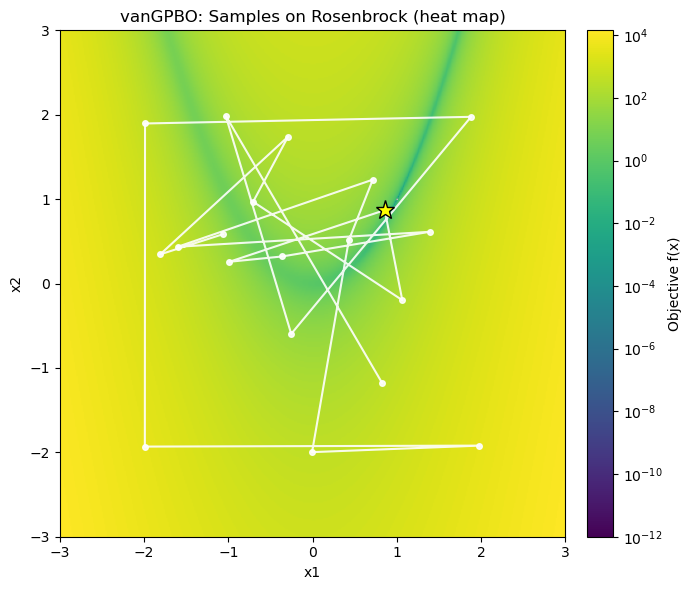

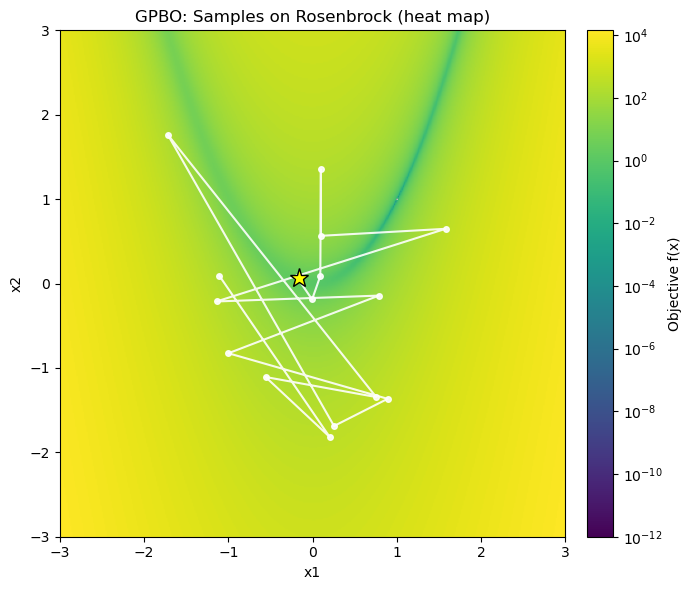

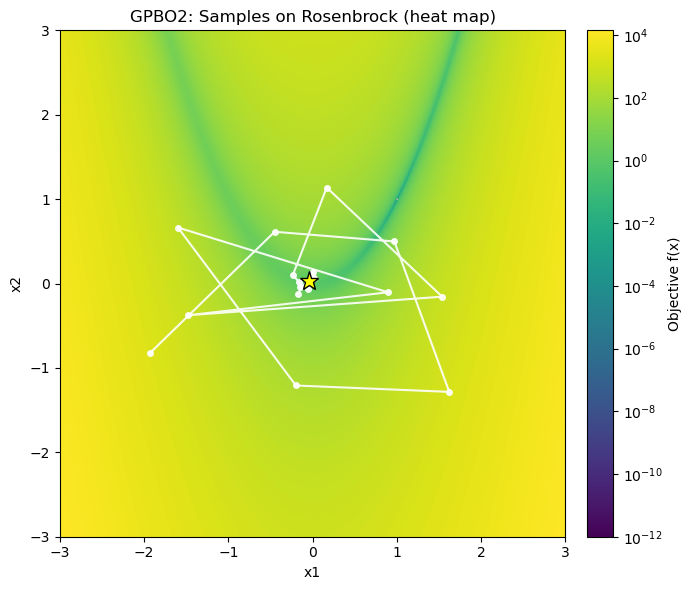

In [6]:
# ----- Rosenbrock grid (deterministic surface for plotting) -----
def rosenbrock_grid(bounds, n=400, a=1.0, b=100.0):
    x1 = np.linspace(bounds[0,0], bounds[0,1], n)
    x2 = np.linspace(bounds[1,0], bounds[1,1], n)
    X1, X2 = np.meshgrid(x1, x2)
    Z = (a - X1)**2 + b * (X2 - X1**2)**2
    return X1, X2, Z

# Build grid for the chosen domain (BOUNDS should be a 2x2 array)
Xg, Yg, Zg = rosenbrock_grid(BOUNDS, n=400)

# ----- Helper to draw one heatmap + sampled points -----
def plot_heat_with_points(X, y, title, bounds, Z, log_scale=True):
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]

    fig, ax = plt.subplots(figsize=(7, 6))

    # Log scaling helps reveal the Rosenbrock valley while showing high regions
    if log_scale:
        # Avoid zero for LogNorm (Rosenbrock min is 0 at [1,1])
        eps = 1e-12
        vmin = max(eps, float(Z.min()) + eps)
        im = ax.imshow(
            Z, extent=(x_min, x_max, y_min, y_max),
            origin='lower', aspect='auto', norm=LogNorm(vmin=vmin, vmax=float(Z.max())),
            cmap='viridis'
        )
    else:
        im = ax.imshow(
            Z, extent=(x_min, x_max, y_min, y_max),
            origin='lower', aspect='auto', cmap='viridis'
        )

    # Overlay sampled points and their path; star = best noisy evaluation
    if X.size:
        ax.plot(X[:, 0], X[:, 1], '-o', lw=1.5, ms=4, color='white', alpha=0.9)
        bi = int(np.argmin(y))
        ax.plot([X[bi, 0]], [X[bi, 1]], marker='*', ms=14, mec='k', mfc='yellow', zorder=3)

    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(False)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Objective f(x)")

    plt.tight_layout()
    return fig, ax

# ----- vanGPBO heat map + points -----
plot_heat_with_points(X,  y,  "vanGPBO: Samples on Rosenbrock (heat map)", BOUNDS, Zg, log_scale=True)

# ----- GPBO heat map + points -----
plot_heat_with_points(X1, y1, "GPBO: Samples on Rosenbrock (heat map)",     BOUNDS, Zg, log_scale=True)

# ----- GPBO2 heat map + points -----
plot_heat_with_points(X2, y2, "GPBO2: Samples on Rosenbrock (heat map)",    BOUNDS, Zg, log_scale=True)

plt.show()


## **Akeley Function Optimisation** 
In this section of the Notebook we will show an optimisation strategy on the Akley Function a more complex version of the Rossenbrock function with a global optima at f(0,0) = 0 


In [7]:

f = lambda x: ackley_noisy(x, noise_std=NOISE_STD)

# --- Run both optimizers for 10 iterations and time them ---
N_ITERS = 10
N_PRE_SAMPLES = 10

np.random.seed(16)

t0 = time.perf_counter()
X1, y1, iters1 = bayesian_optimization_with_trust_region(
    n_iters=N_ITERS,
    sample_loss=f,
    bounds=bounds,
    n_pre_samples=N_PRE_SAMPLES,
    alpha=0.12,
    initial_trust_radius=1.8,
    length_scale=0.8,
    xi=0.01,
    shrink_factor=0.9,
    expand_factor=1.1,
    num_samples=1200,
)
t1 = time.perf_counter()
time_gpbo = t1 - t0

t0 = time.perf_counter()
X2, y2, iters2 = bayesian_optimization_with_trust_region_fast(
    n_iters=N_ITERS,
    sample_loss=f,
    bounds=bounds,
    n_pre_samples=N_PRE_SAMPLES,
    alpha=0.12,
    initial_trust_radius=1.8,
    length_scale=0.8,
    xi=0.01,
    shrink_factor=0.9,
    expand_factor=1.1,
    num_samples=1200,
)
t1 = time.perf_counter()
time_gpbo2 = t1 - t0

t0 = time.perf_counter()
X, y, it = bayesian_optimization(
    n_iters=N_ITERS,
    sample_loss=ackley_noisy,
    bounds=bounds,
    n_pre_samples=N_PRE_SAMPLES,
    alpha=0.12,
    length_scale=0.8,
    xi=0.01,
    num_samples=1200,
)
t1 = time.perf_counter()
time_vangpbo = t1 - t0

print(f"GPBO time (s):  {time_gpbo:.4f}")
print(f"GPBO2 time (s): {time_gpbo2:.4f}")
print(f"vanGPBO time (s): {time_vangpbo:.4f}")

# Best-so-far (useful for plotting)
best4 = np.minimum.accumulate(y1) if y1.size else np.array([])
best5 = np.minimum.accumulate(y2) if y2.size else np.array([])
best6 = np.minimum.accumulate(y) if y.size else np.array([])

# Timing table
df_time = pd.DataFrame({
    "Algorithm": ["GPBO", "GPBO2", "vanGPBO"],
    "Time (s)": [time_gpbo, time_gpbo2, time_vangpbo],
    "Evaluations": [len(y1), len(y2), len(y)],
})
df_time




Iteration 1/10, X_next = [1.98647442 1.63751987], y_next = 2.0269183433974183, Trust Region Center = [ 0.78644286 -0.14294365], Radius = [1.62 1.62]
Iteration 2/10, X_next = [0.10773286 1.44243416], y_next = 1.7040359041732391, Trust Region Center = [ 0.78644286 -0.14294365], Radius = [1.458 1.458]
Iteration 3/10, X_next = [ 1.99990268 -0.45619168], y_next = 1.911490261205482, Trust Region Center = [ 0.78644286 -0.14294365], Radius = [1.3122 1.3122]
Iteration 4/10, X_next = [-0.07525228  0.22754262], y_next = 0.5270211602345848, Trust Region Center = [-0.07525228  0.22754262], Radius = [1.44342 1.44342]
Iteration 5/10, X_next = [-1.49029119 -1.2083978 ], y_next = 1.9136776024256505, Trust Region Center = [-0.07525228  0.22754262], Radius = [1.299078 1.299078]
Iteration 6/10, X_next = [-0.19551573 -0.14646006], y_next = 0.59460791617343, Trust Region Center = [-0.07525228  0.22754262], Radius = [1.1691702 1.1691702]
Iteration 7/10, X_next = [-0.34609863  0.28631446], y_next = 1.18691702

,Algorithm,Time (s),Evaluations
0,GPBO,0.578076,20
1,GPBO2,0.007228,20
2,vanGPBO,0.463791,20


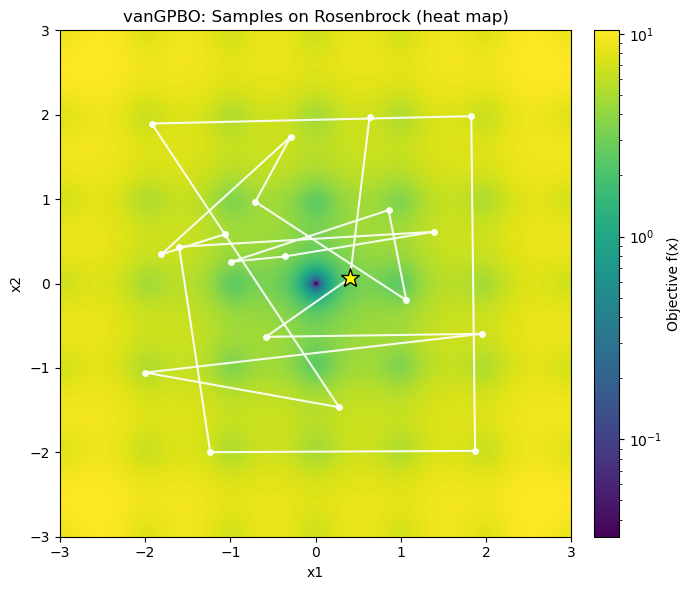

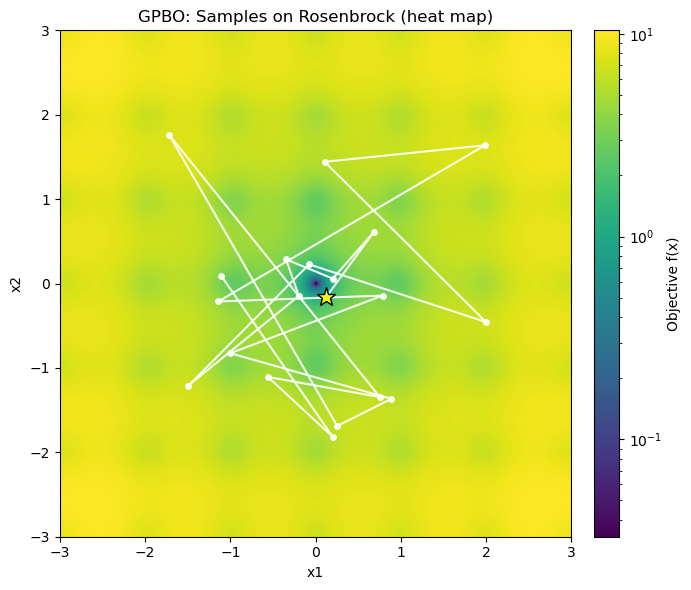

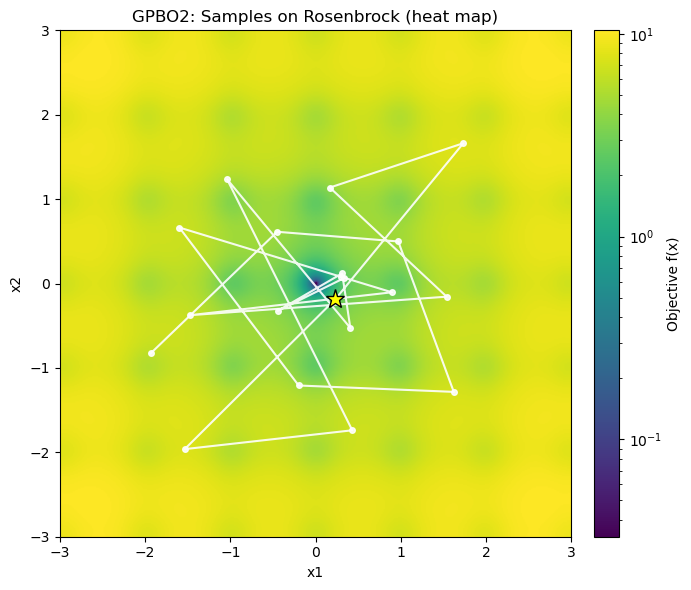

In [8]:

Xg, Yg, Zg = ackley_grid(BOUNDS, n=400)

# ----- Helper to draw one heatmap + sampled points -----
def plot_heat_with_points(X, y, title, bounds, Z, log_scale=True):
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]

    fig, ax = plt.subplots(figsize=(7, 6))

    # Choose normalization: log-scale helps show structure across the domain
    if log_scale:
        # avoid zero values for LogNorm; Rosenbrock >= 0, so add a tiny epsilon
        eps = 1e-8
        norm = LogNorm(vmin=max(eps, Z.min()+eps), vmax=Z.max())
        im = ax.imshow(Z, extent=(x_min, x_max, y_min, y_max),
                       origin='lower', aspect='auto', norm=norm, cmap='viridis')
    else:
        im = ax.imshow(Z, extent=(x_min, x_max, y_min, y_max),
                       origin='lower', aspect='auto', cmap='viridis')

    # Overlay sampled points and a path
    if X.size:
        ax.plot(X[:, 0], X[:, 1], '-o', lw=1.5, ms=4, color='white', alpha=0.9)
        # Highlight best point found
        bi = int(np.argmin(y))
        ax.plot([X[bi, 0]], [X[bi, 1]], marker='*', ms=14, mec='k', mfc='yellow', zorder=3)

    # Labels & colorbar
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(False)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Objective f(x)")

    plt.tight_layout()
    return fig, ax

# ----- vanGPBO heat map + points -----
plot_heat_with_points(X, y, "vanGPBO: Samples on Rosenbrock (heat map)", BOUNDS, Zg, log_scale=True)

# ----- GPBO heat map + points -----
plot_heat_with_points(X1, y1, "GPBO: Samples on Rosenbrock (heat map)", BOUNDS, Zg, log_scale=True)

# ----- GPBO2 heat map + points -----
plot_heat_with_points(X2, y2, "GPBO2: Samples on Rosenbrock (heat map)", BOUNDS, Zg, log_scale=True)
plt.show()


## **Algorithm Performance Interpretation**

**optimisation**
As seen by the two figures below trust region BO performs best when the design space is moderately complex like that of the Rossenbrock function. These changes then become less significant with more complex design space like that of the Aukley function where the trust region BO algorithm risks converging towards a local minima.

**Computational Time**
Due to time constraints for the lab coursework the algorithm computational efficiency was not a priority. GPBO2 shows greater performance boosts through vectorisation. However this can be improved further in future work.

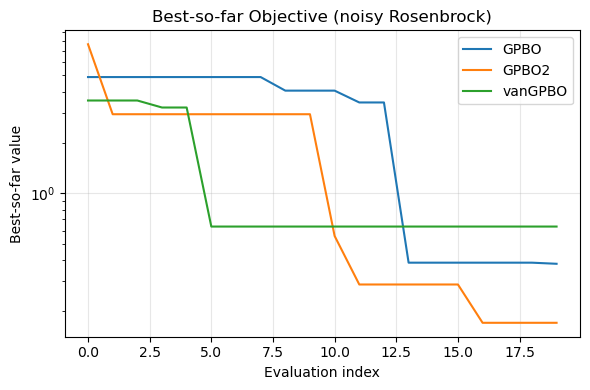

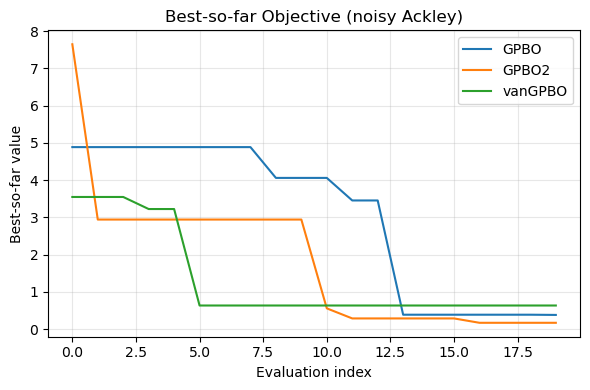

In [9]:
eps = 1e-10  # keep values > 0 for log scale

plt.figure(figsize=(6,4))
if best1.size:
    plt.plot(np.arange(len(best1)), np.maximum(best1, eps), label="GPBO")
if best2.size:
    plt.plot(np.arange(len(best2)), np.maximum(best2, eps), label="GPBO2")
if best3.size:
    plt.plot(np.arange(len(best3)), np.maximum(best3, eps), label="vanGPBO")

plt.yscale("log")  # Rosenbrock spans many orders of magnitude
plt.title("Best-so-far Objective (noisy Rosenbrock)")
plt.xlabel("Evaluation index")
plt.ylabel("Best-so-far value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()


# --- Best-so-far objective vs evaluation ---
plt.figure(figsize=(6,4))
if best1.size:
    plt.plot(np.arange(len(best1)), best1, label="GPBO")
if best2.size:
    plt.plot(np.arange(len(best2)), best2, label="GPBO2")
if best3.size:
    plt.plot(np.arange(len(best3)), best3, label="vanGPBO")
plt.title("Best-so-far Objective (noisy Ackley)")
plt.xlabel("Evaluation index")
plt.ylabel("Best-so-far value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()